In [1]:
import cartopy 
import cartopy.crs as ccrs
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
from numpy import cov
%matplotlib inline
import pandas as pd
import cftime
import nc_time_axis
import cartopy.feature as cf
import xarray as xr
from mpl_toolkits.mplot3d import Axes3D
%config inlinebackend.figure_format = 'retina'

In [33]:
# Loading Sulfate Data
!wget https://data.giss.nasa.gov/modelforce/trop.aer/SUL_Koch2008_kg_m2_144x90x20_1890-2000h.nc
# Loading Industrial Black Carbon Data
!wget https://data.giss.nasa.gov/modelforce/trop.aer/BCA_Koch2008_kg_m2_144x90x20_1890-2000h.nc
# Loading Precipitation Monthly Mean Data
!wget https://ndownloader.figshare.com/files/20074430

--2019-12-04 13:49:14--  https://data.giss.nasa.gov/modelforce/trop.aer/SUL_Koch2008_kg_m2_144x90x20_1890-2000h.nc
Resolving data.giss.nasa.gov... 129.164.128.233
Connecting to data.giss.nasa.gov|129.164.128.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149301652 (142M) [application/x-netcdf]
Saving to: 'SUL_Koch2008_kg_m2_144x90x20_1890-2000h.nc.1'

SUL_Koch2008_kg_m2_ 100%[===================>] 142.38M  4.46MB/s    in 34s     

2019-12-04 13:49:48 (4.19 MB/s) - 'SUL_Koch2008_kg_m2_144x90x20_1890-2000h.nc.1' saved [149301652/149301652]

--2019-12-04 13:49:48--  https://data.giss.nasa.gov/modelforce/trop.aer/BCA_Koch2008_kg_m2_144x90x20_1890-2000h.nc
Resolving data.giss.nasa.gov... 129.164.128.233
Connecting to data.giss.nasa.gov|129.164.128.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149301672 (142M) [application/x-netcdf]
Saving to: 'BCA_Koch2008_kg_m2_144x90x20_1890-2000h.nc.1'

BCA_Koch2008_kg_m2_ 100%[==============

In [2]:
# Naming Data
sulfate = 'SUL_Koch2008_kg_m2_144x90x20_1890-2000h.nc'
BC = 'BCA_Koch2008_kg_m2_144x90x20_1890-2000h.nc'

Both of the Aerosol Data (Sulfate and Black Carbon) have strange formatting in the Time dimension. This had to be resolved using the cftime and nc_time_axis package, which was rather inconvenient. 

In [3]:
# Subsetting Sulfate Aerosol data for 1979-1990
ds = xr.open_dataset(sulfate,decode_times=False)

def fix_calendar(ds, timevar='time'):
    if ds[timevar].attrs['calendar'] == '360':
        ds[timevar].attrs['calendar'] = '360_day'
    return ds

ds['time'].attrs['calendar'] = '360_day'
ds['time'].attrs['units'] = 'months since 1890-01-01'

ds = fix_calendar(ds)
ds = xr.decode_cf(ds)

ds = ds.sel(time=slice('1980-01-01','2000-12-01'),lon=slice(60,140),lat=slice(0,90))

In [4]:
db = xr.open_dataset(BC,decode_times=False)

def fix_calendar(db, timevar='time'):
    if db[timevar].attrs['calendar'] == '360':
        db[timevar].attrs['calendar'] = '360_day'
    return db

db['time'].attrs['calendar'] = '360_day'
db['time'].attrs['units'] = 'months since 1890-01-01'

db = fix_calendar(db)
db = xr.decode_cf(db)

db = db.sel(time=slice('1980-01-01','2000-12-01'),lon=slice(60,140),lat=slice(0,90))

In [5]:
dp = xr.open_dataset('20074430')
dp = dp.reindex(lat=dp.lat[::-1])
dp = dp.sel(time=slice('1980-01-01','2000-12-01'),lon=slice(60,140),lat=slice(0,90))

At this step, I am subsetting the data in to time periods of interest for my analysis: 1980, 1990, 2000, and 1980-2000. 

In [7]:
# 1980 Averaged
eighties = ds.sel(time=slice('1980-01-01','1980-12-01')).mean(dim='lev')
bceight = db.sel(time=slice('1980-01-01','1980-12-01')).mean(dim='lev')
precipeight = dp.sel(time=slice('1980-01-01','1980-12-01'))
# 1990 Averaged 
nineties = ds.sel(time=slice('1990-01-01','1990-12-01')).mean(dim='lev')
bcnine = db.sel(time=slice('1990-01-01','1990-12-01')).mean(dim='lev')
precipnine = dp.sel(time=slice('1990-01-01','1990-12-01'))
# 2000 Averaged
twok = ds.sel(time=slice('2000-01-01','2000-12-01')).mean(dim='lev')
bctwok = db.sel(time=slice('2000-01-01','2000-12-01')).mean(dim='lev')
preciptwenty = dp.sel(time=slice('2000-01-01','2000-12-01'))
# time Averaged
total = ds.sel(time=slice('1980-01-01','2000-12-01')).mean(dim='lev')
bctotal = db.sel(time=slice('1980-01-01','2000-12-01')).mean(dim='lev')
precipen = precipeight.merge(precipnine)
precipall = precipen.merge(preciptwenty)

In [8]:
# Creating Values
months = ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec')
# Sulfate Values
eightval = eighties.SUL.mean(dim=('lat','lon')).values
nineval = nineties.SUL.mean(dim=('lat','lon')).values
twokval = twok.SUL.mean(dim=('lat','lon')).values
totalavg = total.SUL.mean(dim=('lat','lon')).values
# Black Carbon Values
bceightval = bceight.BCA.mean(dim=('lat','lon')).values
bcnineval = bcnine.BCA.mean(dim=('lat','lon')).values
bctwokval = bctwok.BCA.mean(dim=('lat','lon')).values
bctotalavg = bctotal.BCA.mean(dim=('lat','lon')).values
# Precipitation Values
precipeightval = precipeight.precip.mean(dim=('lat','lon')).values
precipnineval = precipnine.precip.mean(dim=('lat','lon')).values
preciptwenval = preciptwenty.precip.mean(dim=('lat','lon')).values
precipallval = precipall.precip.mean(dim=('lat','lon')).values

In [34]:
# Detrending Signals
sedt = signal.detrend(eightval,type='linear')
sndt = signal.detrend(nineval,type='linear')
stdt = signal.detrend(twokval,type='linear')
sadt = signal.detrend(totalavg,type='linear')

bcedt = signal.detrend(bceightval,type='linear')
bcndt = signal.detrend(bcnineval,type='linear')
bctdt = signal.detrend(bctwokval,type='linear')
bcadt = signal.detrend(bctotalavg,type='linear')

precipedt = signal.detrend(precipeightval,type='linear')
precipndt = signal.detrend(precipnineval,type='linear')
preciptdt = signal.detrend(preciptwenval,type='linear')
precipadt = signal.detrend(precipallval,type='linear')

My first figure is a visualization of the distribution of Sulfate, Black Carbon, and Precipitation from 1980-2000. When first starting the project and choosing this dataset, I did not think about the possibility of my dataset not being normally distributed. This makes gives me limited opportunities in the types of statistical testing that is possible. 

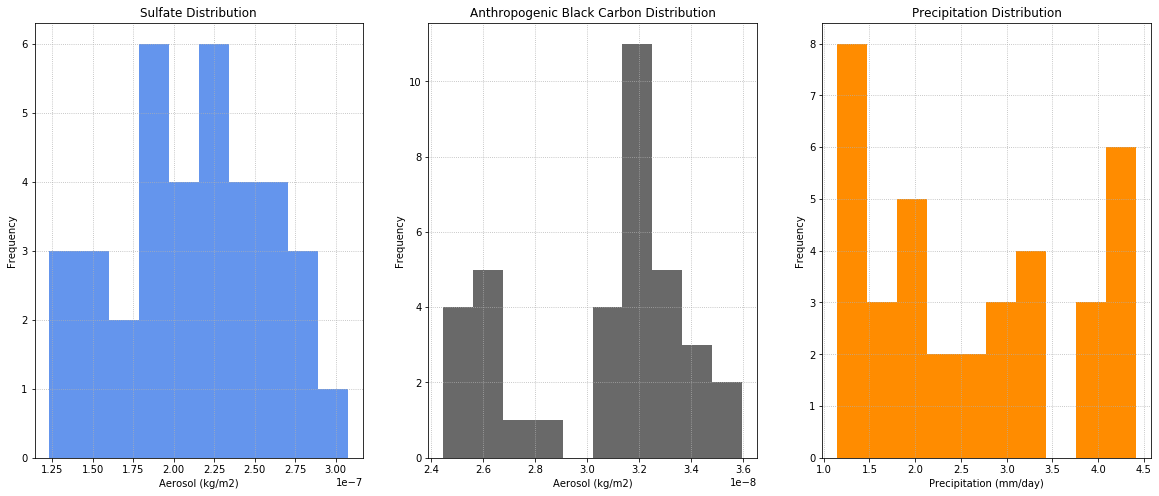

In [9]:
fig, ax = plt.subplots(ncols=3,figsize = (20,8))

total.SUL.mean(dim=('lat','lon')).plot.hist(ax=ax[0],color='cornflowerblue')
ax[0].set_title('Sulfate Distribution')
ax[0].set_xlabel('Aerosol (kg/m2)')
ax[0].set_ylabel('Frequency')
ax[0].grid(which='minor', linestyle=':')
ax[0].grid(which='major', linestyle=':')

bctotal.BCA.mean(dim=('lat','lon')).plot.hist(ax=ax[1],color='dimgray')
ax[1].set_title('Anthropogenic Black Carbon Distribution')
ax[1].set_xlabel('Aerosol (kg/m2)')
ax[1].set_ylabel('Frequency')
ax[1].grid(which='minor', linestyle=':')
ax[1].grid(which='major', linestyle=':')

precipall.precip.mean(dim=('lat','lon')).plot.hist(ax=ax[2],color='darkorange')
ax[2].set_title('Precipitation Distribution')
ax[2].set_xlabel('Precipitation (mm/day)')
ax[2].set_ylabel('Frequency')
ax[2].grid(which='minor', linestyle=':')
ax[2].grid(which='major', linestyle=':')

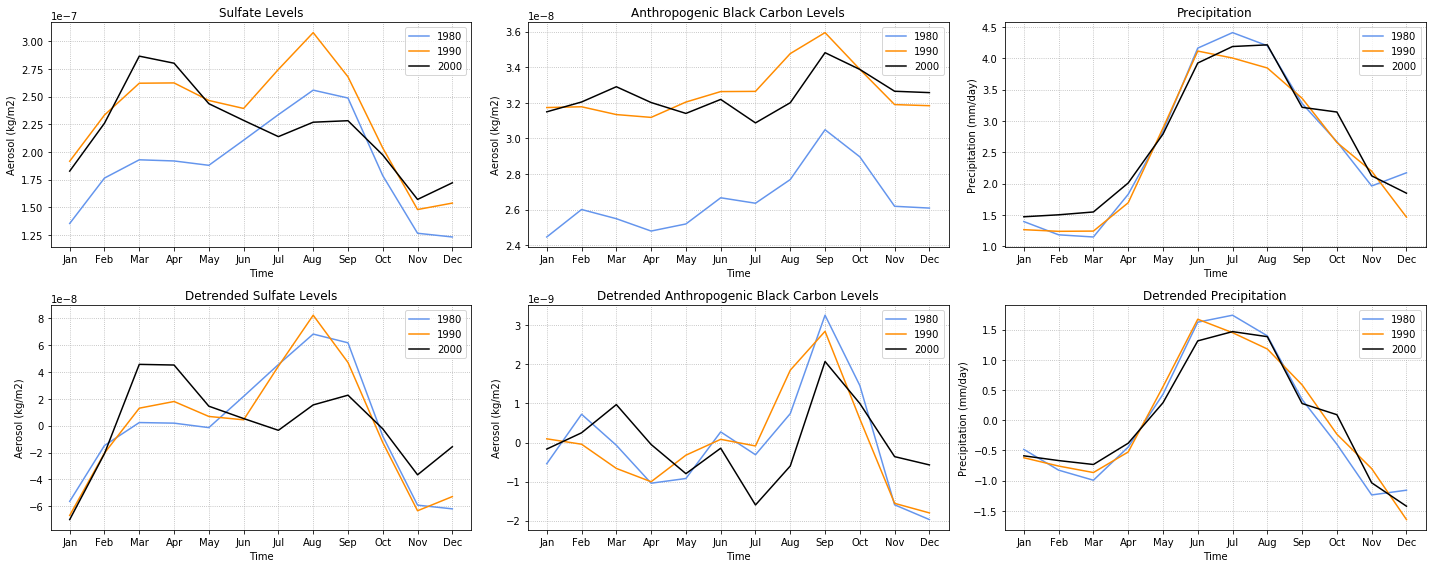

In [33]:
fig, ax = plt.subplots(nrows=2,ncols=3,figsize = (20,8))
# Sulfate and BCA Levels
ax[0,0].plot(months,eightval,color='cornflowerblue',label='1980')
ax[0,0].plot(months,nineval,color='darkorange',label='1990')
ax[0,0].plot(months,twokval,color='black',label='2000')
ax[0,0].set_title('Sulfate Levels')
ax[0,0].set_xlabel('Time')
ax[0,0].set_ylabel('Aerosol (kg/m2)')
ax[0,0].grid(which='minor', linestyle=':')
ax[0,0].grid(which='major', linestyle=':')
ax[0,0].legend()

ax[0,1].plot(months,bceightval,color='cornflowerblue',label='1980')
ax[0,1].plot(months,bcnineval,color='darkorange',label='1990')
ax[0,1].plot(months,bctwokval,color='black',label='2000')
ax[0,1].set_title('Anthropogenic Black Carbon Levels')
ax[0,1].set_xlabel('Time')
ax[0,1].set_ylabel('Aerosol (kg/m2)')
ax[0,1].grid(which='minor', linestyle=':')
ax[0,1].grid(which='major', linestyle=':')
ax[0,1].legend()

# Precipitation Data
ax[0,2].plot(months,precipeightval,color='cornflowerblue',label='1980')
ax[0,2].plot(months,precipnineval,color='darkorange',label='1990')
ax[0,2].plot(months,preciptwenval,color='black',label='2000')
ax[0,2].set_title('Precipitation')
ax[0,2].set_xlabel('Time')
ax[0,2].set_ylabel('Precipitation (mm/day)')
ax[0,2].grid(which='minor', linestyle=':')
ax[0,2].grid(which='major', linestyle=':')
ax[0,2].legend()

# Detrended Sulfate and BCA Levels
ax[1,0].plot(months,sedt,color='cornflowerblue',label='1980')
ax[1,0].plot(months,sndt,color='darkorange',label='1990')
ax[1,0].plot(months,stdt,color='black',label='2000')
ax[1,0].set_title('Detrended Sulfate Levels')
ax[1,0].set_xlabel('Time')
ax[1,0].set_ylabel('Aerosol (kg/m2)')
ax[1,0].grid(which='minor', linestyle=':')
ax[1,0].grid(which='major', linestyle=':')
ax[1,0].legend()

ax[1,1].plot(months,bcedt,color='cornflowerblue',label='1980')
ax[1,1].plot(months,bcndt,color='darkorange',label='1990')
ax[1,1].plot(months,bctdt,color='black',label='2000')
ax[1,1].set_title('Detrended Anthropogenic Black Carbon Levels')
ax[1,1].set_xlabel('Time')
ax[1,1].set_ylabel('Aerosol (kg/m2)')
ax[1,1].grid(which='minor', linestyle=':')
ax[1,1].grid(which='major', linestyle=':')
ax[1,1].legend()

#Detrended Precipitation
ax[1,2].plot(months,precipedt,color='cornflowerblue',label='1980')
ax[1,2].plot(months,precipndt,color='darkorange',label='1990')
ax[1,2].plot(months,preciptdt,color='black',label='2000')
ax[1,2].set_title('Detrended Precipitation')
ax[1,2].set_xlabel('Time')
ax[1,2].set_ylabel('Precipitation (mm/day)')
ax[1,2].grid(which='minor', linestyle=':')
ax[1,2].grid(which='major', linestyle=':')
ax[1,2].legend()

fig.tight_layout()


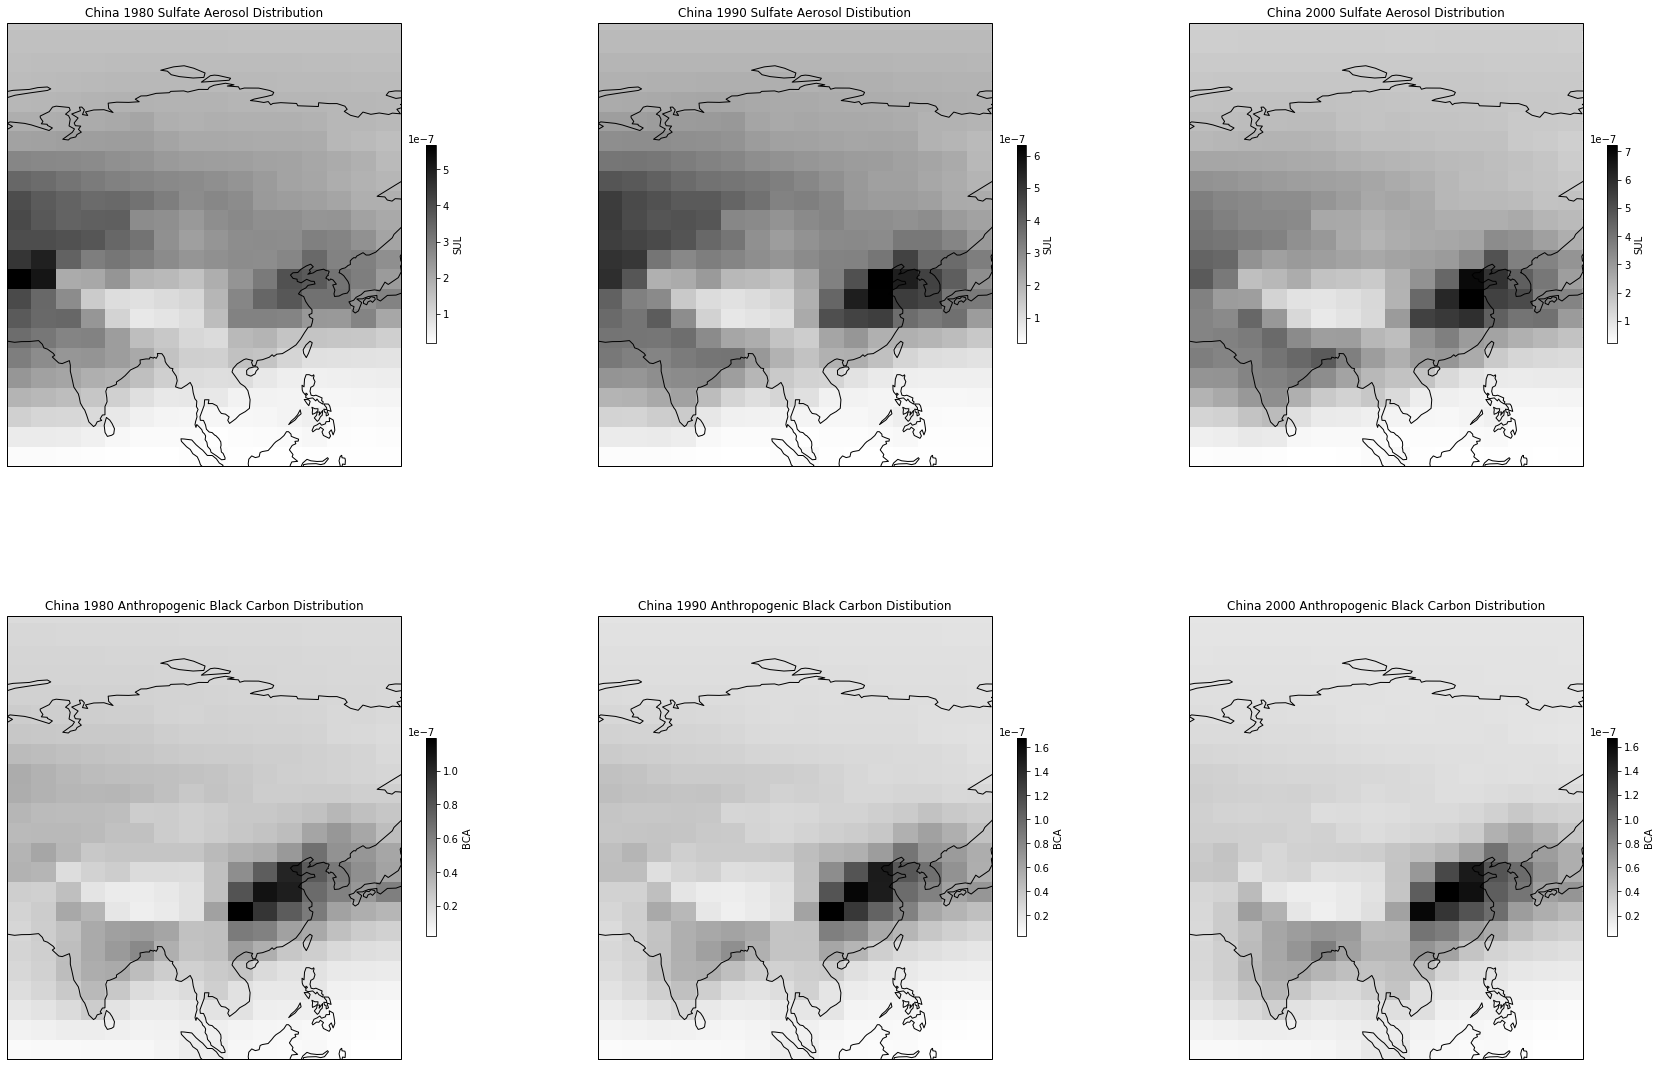

In [42]:
em = eighties.SUL.mean('time')
nm = nineties.SUL.mean('time')
twm = twok.SUL.mean('time')
tm = total.SUL.mean('time')

bcem = bceight.BCA.mean('time')
bcnm = bcnine.BCA.mean('time')
bctwnm = bctwok.BCA.mean('time')

extentant = [60, 140, 0,90]
project_china = ccrs.PlateCarree()
fig, ax = plt.subplots(ncols = 3, nrows=2, figsize = (30,20), subplot_kw={'projection': project_china})

em.plot(ax=ax[0,0], transform=ccrs.PlateCarree(),cmap='binary',cbar_kwargs={'shrink':0.4})
ax[0,0].set_title('China 1980 Sulfate Aerosol Distribution')

nm.plot(ax=ax[0,1], transform=ccrs.PlateCarree(),cmap='binary',cbar_kwargs={'shrink':0.4})
ax[0,1].set_title('China 1990 Sulfate Aerosol Distibution')

twm.plot(ax=ax[0,2], transform = ccrs.PlateCarree(),cmap='binary',cbar_kwargs={'shrink':0.4})
ax[0,2].set_title('China 2000 Sulfate Aerosol Distribution')

bcem.plot(ax=ax[1,0], transform=ccrs.PlateCarree(),cmap='binary',cbar_kwargs={'shrink':0.4})
ax[1,0].set_title('China 1980 Anthropogenic Black Carbon Distribution')

bcnm.plot(ax=ax[1,1], transform=ccrs.PlateCarree(),cmap='binary',cbar_kwargs={'shrink':0.4})
ax[1,1].set_title('China 1990 Anthropogenic Black Carbon Distibution')

bctwnm.plot(ax=ax[1,2], transform = ccrs.PlateCarree(),cmap='binary',cbar_kwargs={'shrink':0.4})
ax[1,2].set_title('China 2000 Anthropogenic Black Carbon Distribution')


for a in ax.flat:
    a.set_extent(extentant, ccrs.PlateCarree())
    a.coastlines()

/Users/cpatrickfly/opt/anaconda3/envs/Aerosol_Analysis/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


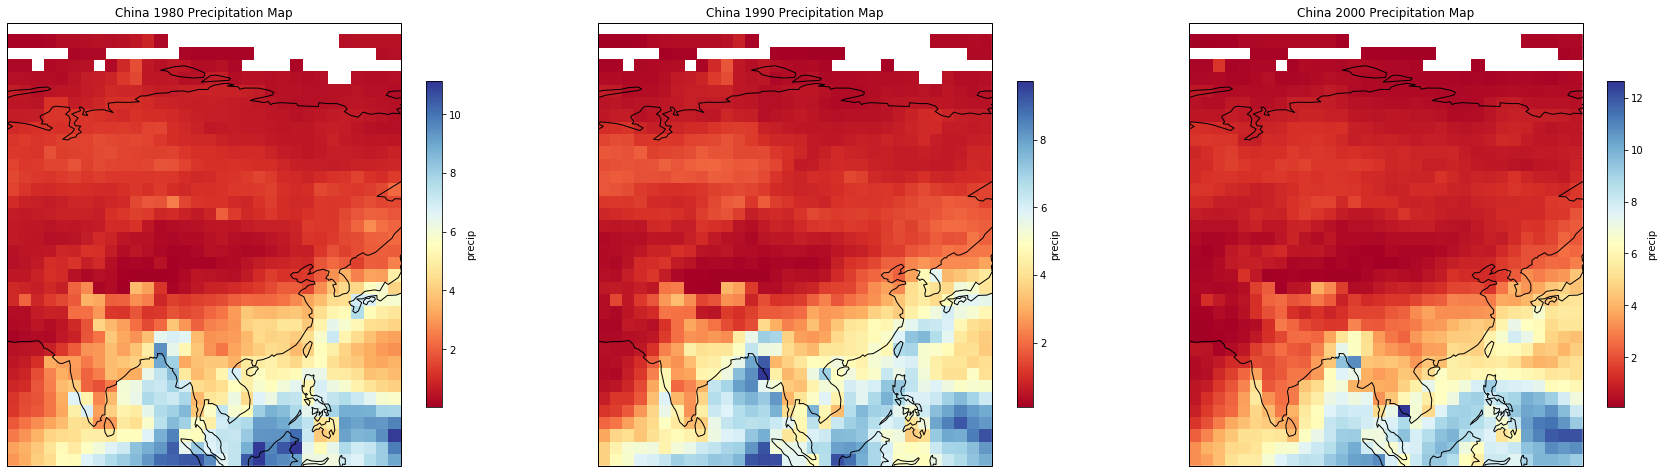

In [43]:
pe = precipeight.precip.mean('time')
pn = precipnine.precip.mean('time')
ptw = preciptwenty.precip.mean('time')
pt = precipall.precip.mean('time')

# Yearly averages of Monthly Precipitation
extentant = [60, 140, 0,90]
project_china = ccrs.PlateCarree()
fig, ax = plt.subplots(ncols = 3, figsize = (30,20), subplot_kw={'projection': project_china})

pe.plot(ax=ax[0], transform=ccrs.PlateCarree(),cmap='RdYlBu',cbar_kwargs={'shrink':0.3})
ax[0].set_title('China 1980 Precipitation Map')

pn.plot(ax=ax[1], transform=ccrs.PlateCarree(),cmap='RdYlBu',cbar_kwargs={'shrink':0.3})
ax[1].set_title('China 1990 Precipitation Map')

ptw.plot(ax=ax[2], transform = ccrs.PlateCarree(),cmap='RdYlBu',cbar_kwargs={'shrink':0.3})
ax[2].set_title('China 2000 Precipitation Map')

for a in ax.flat:
    a.set_extent(extentant, ccrs.PlateCarree())
    a.coastlines()

In [41]:
# Setting Variables
x = totalavg
y = precipallval
z = bctotalavg

# Correlations
xycorr = np.corrcoef(x,y)
xzcorr = np.corrcoef(x,z)
zycorr = np.corrcoef(z,y)

#R2 values
xyR2 = xycorr**2
xzR2 = xzcorr**2
zyR2 = zycorr**2

print(xyR2)
print(xzR2)
print(zyR2)

[[1.         0.14607463]
 [0.14607463 1.        ]]
[[1.         0.23829599]
 [0.23829599 1.        ]]
[[1.         0.02873771]
 [0.02873771 1.        ]]


In [42]:
# Detrended Values 

# Setting Detrended Variables 
s = sadt
p = precipadt
b = bcadt

# Detrended Correlations
spcorr = np.corrcoef(s,p)
sbcorr = np.corrcoef(s,b)
pbcorr = np.corrcoef(p,b)

# Detrended R2 Values
spR2 = spcorr**2
sbR2 = sbcorr**2
pbR2 = pbcorr**2

print(spR2)
print(sbR2)
print(pbR2)

[[1.         0.13426401]
 [0.13426401 1.        ]]
[[1.        0.3408474]
 [0.3408474 1.       ]]
[[1.         0.00781548]
 [0.00781548 1.        ]]


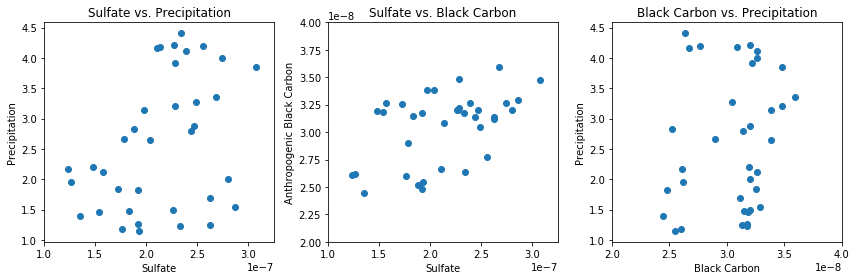

In [53]:
fig, ax = plt.subplots(ncols= 3, figsize = (12,4))

ax[0].scatter(x,y)
ax[0].set_xlim(1e-07,3.25e-07)
ax[0].set_xlabel('Sulfate')
ax[0].set_ylabel('Precipitation')
ax[0].set_title('Sulfate vs. Precipitation')

ax[1].scatter(x,z)
ax[1].set_xlim(1e-07,3.25e-07)
ax[1].set_ylim(2e-08,4e-08)
ax[1].set_xlabel('Sulfate')
ax[1].set_ylabel('Anthropogenic Black Carbon')
ax[1].set_title('Sulfate vs. Black Carbon')

ax[2].scatter(z,y)
ax[2].set_xlim(2e-08,4e-08)
ax[2].set_xlabel('Black Carbon')
ax[2].set_ylabel('Precipitation')
ax[2].set_title('Black Carbon vs. Precipitation')

fig.tight_layout()


Sulfate and Black Carbon seem to decrease global average precipitation because particles decrease the size of water droplets in clouds. However, locally, it seems that aerosols may increase and decrease precipitation, it is not exactly clear. 

These scatter plots visualize the relationship between each of these variables. Sulfate and Precipitation have a low positive correlation value of 0.15, which is to be expected. With a sample size this small, it is difficult to fish out a relationship between the two variables. Both data sets are also not normall distributed and it is unclear whether they have a linear relationship and have homoscedasticity. 

Sulfate and Black Carbon have a higher correlation value of ~0.24. This makes sense to me as they are both anthropogenic inputs and should increase together, however, the small correlation values are not very meaningful. Again, I believe that the correlation values are low due to the low sample size and the distribution of these variables. 

Black carbon and precipitation has the lowest correlation of ~.03, it is most likley within this data that they have no correlation for the same reason as above.

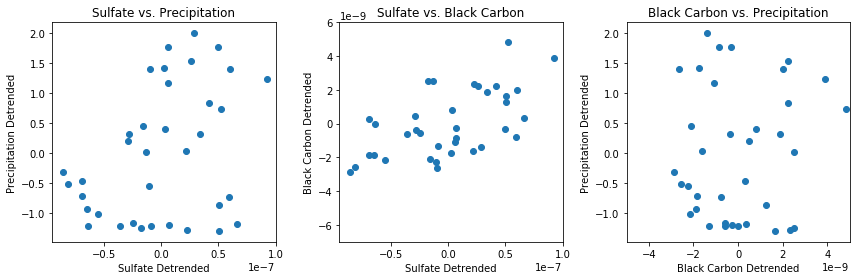

In [79]:
# Detrended Scatter Plots 
fig, ax = plt.subplots(ncols= 3, figsize = (12,4))

ax[0].scatter(s,p)
ax[0].set_xlim(-9.5e-08,10e-08)
ax[0].set_xlabel('Sulfate Detrended')
ax[0].set_ylabel('Precipitation Detrended')
ax[0].set_title('Sulfate vs. Precipitation')

ax[1].scatter(s,b)
ax[1].set_xlim(-9.5e-08,10e-08)
ax[1].set_ylim(-7e-09,6e-09)
ax[1].set_xlabel('Sulfate Detrended')
ax[1].set_ylabel('Black Carbon Detrended')
ax[1].set_title('Sulfate vs. Black Carbon')

ax[2].scatter(b,p)
ax[2].set_xlim(-5e-09,5e-09)
ax[2].set_xlabel('Black Carbon Detrended')
ax[2].set_ylabel('Precipitation Detrended')
ax[2].set_title('Black Carbon vs. Precipitation')

fig.tight_layout()

Once I detrended the data, the R2 squared values decreased in Sulfate vs Precipitation from 0.15 to 0.13; Sulfate vs Black Carbon increased from ~0.24 to ~0.34, and Black Carbon vs. Precipitation decreased from ~.03 to ~.008. The detrended correlation values indicate that in general there is very weak correlation between aerosols and precipitation and there is a weak positive correlation between sulfate and black carbon. Whether it is the detrended or the trended correlations, they both point that there is no correlation, if not, a very weak correlation between aerosols and precipitation. 

While conducting these analysis, I considered normalizing the data set into Z scores or Spearman Ranks. However, I felt that modifying the data into these values convolutes the interpretation of the data. I do not think Z scores and Spearman correlation values will provide much meaning into this analysis. Perhaps, if the dataset was larger there might be more meaning in the Z scores, but I think in terms of the relationship between the aerosols and precipitation, z score may not be useful; spearman correlation even more so. I felt that trying to conduct non-parametric tests on this dataset was trying to force the data into telling something I wanted to know. If there was more samples, this may have been more appropriate. 

Overall, my recommendation will be to use a larger data set that maybe spans 1900-2019. Whether that is using combined proxy and modeling data, a larger time span that is higher resolution is crucial for conducting this analysis properly. I also believe that the influence of anthropogenic aerosol on precipitation will be not be powerful in China. Unlike a volcanic eruptions, where the input of aerosols are significant, I don't think that gradual input of anthropogenic aerosol has been large enough to cause a significant change in the hydrology of China. I think that there may be a small factor in the affecting the hydrology, but I believe that large climate events such as the Asian Monsoon will have a larger contribution to the precipatition levels.

I also think that another interesting question to consider that may be more effected by anthropogenic aerosol levels is gross and net primary production's relation to aerosol increases around the world.